# Neural Style Transfer CNNs
By David Tarazi and Dieter Brehm, October 2019
## Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# show live results
tf.enable_eager_execution()

In [3]:
# download two test images
content_path = tf.keras.utils.get_file('olin.jpg','https://github.com/Inkering/ML-Project-1/blob/master/71934026_761426527628858_7267766954746707968_n.png?raw=true')
style_path = tf.keras.utils.get_file('painting.jpg','https://github.com/Inkering/ML-Project-1/raw/master/StarryNight.jpg')

## Quick Possibility Test - Keras Quick Model
More of a proof of concept than the approach we are taking, this uses keras' built in model handler without any tuning and applies our images to it. VGG is a 19-layer CNN neural network model primarily used for object classification. However, such a network does classification by identifying important features in images and performing comparisions. Therefore, this feature identification makes for a useful way to implement automatically applying the style of one image onto the other.

### Functions for normalizing and dealing with images

In [4]:
def transform_image(img_path, dim):
    # load the image into a variable
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
 
    # look at size of the image, get the longest dimension
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    
    # calculate a scale factor to fit to the desired dims
    scale = dim / long_dim

    # calculate the new dimensions
    new_shape = tf.cast(shape * scale, tf.int32)
    
    # resize the image vector
    img = tf.image.resize(img, new_shape)
    
    # what does this do?
    img = img[tf.newaxis, :]
    
    return img

In [5]:
# quick function for plotting an image, gets rid of num_frames?
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

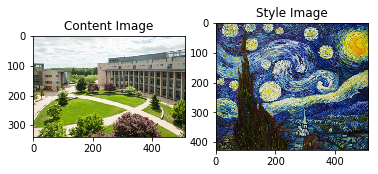

In [6]:
# scale images 
content_image = transform_image(content_path, 512)
style_image = transform_image(style_path, 512)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### Taking a look at how Keras VGG19 classification works

Here's some additional information about the vgg 19 layer pretrained model we are utilizing:

**Keras Docs**  
https://keras.io/applications/#vgg19

**ImageNets Docs**  
http://image-net.org/explore.php

In [7]:
# input post-scaled image into vgg model, normalize
# input to how the model was trained
x = tf.keras.applications.vgg19.preprocess_input(content_image*200)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


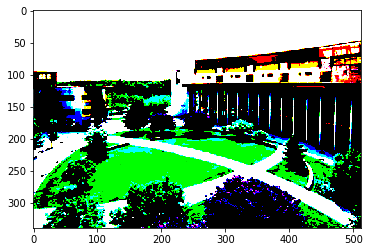

In [8]:
# look at normalized image to the model set,
#(according to keras)
imshow(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


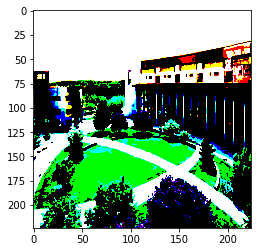

In [9]:
# resize input into a square
x = tf.image.resize(x, (224, 224))
imshow(x)

In [10]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [11]:
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([Dimension(1), Dimension(1000)])

In [12]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('palace', 0.27103126),
 ('monastery', 0.121630244),
 ('patio', 0.0721746),
 ('mosque', 0.065551676),
 ('sundial', 0.033055462)]

We didn't build this, but here is the result we will get towards later in the document:

In [13]:
import tensorflow_hub as hub
import numpy as np
import PIL.Image
import time
import functools

In [14]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

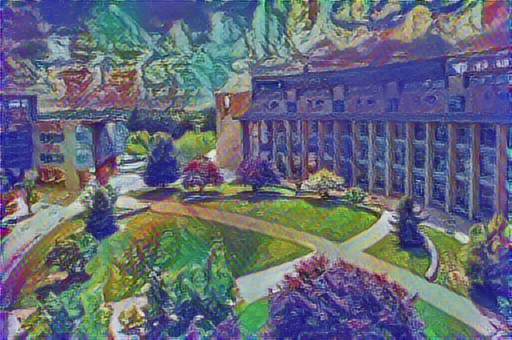

In [15]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Tensorflow implementation with further tuning and adjustments (Take 2, Getting less abstract)

**A note on how the loss function works in this implementation**:  
Basically, the content loss function is calculating the sum of the mean squared
error between the generated image and the content image. The activations in the
higher layers of the generated image often represent objects shown in the
image. So the content loss function focuses on the higher layers correlated
specifically to objects or content.

On the other hand, the style loss function looks at all of the layers in the
CNN. style information is measured as the amount of correlation present between
features maps in a given layer. Next, a loss is defined as the difference of
correlation present between the feature maps computed by the generated image and
the style image.

first, load the vgg model:

In [16]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

All of the layers in our model, as provided by keras API. We can look at each layer and learn about it!  
  
current understanding: by looking at an intermediary layer of the vgg network before any classification "squashing" occurs, we can use particular layer levels as the primary styles to transfer over between two images.

In [17]:
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


So lets pick some layers for our content and style mapping.
  
**Q**: How does the number of style layers chosen, and which content layer chosen, change the algorithm output?

In [18]:
content_layers = ['block5_conv3']
style_layers = ["block1_conv2",
                "block2_conv2",
                "block3_conv2",
                "block4_conv2",
                "block5_conv2"]


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In order to make it easier to access layers and interact with the pretrained, model, we can turn it into a keras model.  

**Q**: What exactly are the inputs/outputs here?

In [19]:
def vgg_2_functional_model(layer_names):
    # download the model
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    # output vectors (tensors) for each layer we care about
    outputs = [vgg.get_layer(name).output for name in layer_names]
    # input vectors (tensors) as the input layer (first layer) of the model
    model = tf.keras.Model([vgg.input], outputs)
    return model

And apply the painting image to it

In [20]:
# create the model, testing using our selected layers
style_model = vgg_2_functional_model(style_layers)
# apply our desired style image (the painting) to the model and get the outputs
style_outputs = style_model(style_image*255)

Create a function handling the gram matrix -> a way to combine multiple style feature vectors into one image.

In [21]:
def gram_matrix(input_tensor):
    # Finds the correlation matrix for style loss and sums all of the feature correlations for a particular layer
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    # num_locations is the same as number of pixels
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    # normalize
    return result/(num_locations)

In [22]:
class StyleContentModel(tf.keras.models.Model):
    """
    Creates a model class that has all the properties of a keras Model with specific style and content layers.
    When called, it takes the inputs and returns a style and content dictionary with the layer and its output.
    """
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_2_functional_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg_trainable = False
        
    def call(self, inputs):
        """
        Overloading the keras Model call method
        """
        # Expects float input in [0,1]
        inputs = inputs*255.0
        # depending on model - resize/process inputs to the right size, shape, etc.
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        # image layers
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])
        
        # Puts the style outputs into their correlation matrix form so that we can compute loss
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [23]:
# Creating and running an instance
model_instance = StyleContentModel(style_layers, content_layers)

results = model_instance.call(tf.constant(content_image))

(1, 64, 64)
(8, 8, 64)


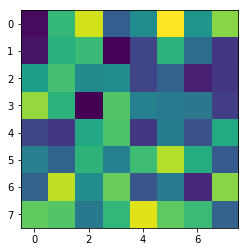

In [24]:
# Each style layer is a tensor that holds style information as a gram matrix
layer_shown = results["style"]["block1_conv2"]
#pluck out a layer and convert to np array
print(layer_shown.shape)
layer_shown = layer_shown*255
layer_shown = np.array(layer_shown, dtype=np.uint8)

#reshape to an image size
layer_shown = np.reshape(layer_shown,(8,8,64))

print(layer_shown.shape)
plt.imshow(layer_shown[:,:,0])

In [25]:
# Setting the targets by pulling them out of the run model instance
style_targets = model_instance(style_image)['style']
content_targets = model_instance(content_image)['content']

# Defining the image as a tensorflow variable to make it constant
image = tf.Variable(content_image)

In [26]:
# Defining the optimizer - we can tune the learning rate and beta value (decay rate for first moment estimates)
opt = tf.train.AdamOptimizer(learning_rate=0.05, beta1=0.99, epsilon=1e-1)

In [27]:
# starting point for the gradient descent on weights
style_weight=1e-2
content_weight=1e4

In [28]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [29]:
def style_content_loss(outputs):
    """
    Finding the loss for both style and content by comparing the generated image to the input image
    """
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [30]:
losses = []
def train_step(image):
    # Tape keeps track of the gradient at every step and differentiates between the weights at each node
    with tf.GradientTape() as tape:
        outputs = model_instance(image)
        loss = style_content_loss(outputs)
        losses.append(loss)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

## Running a Controlled Exeriment

In [31]:
def run(epoch, num_steps):
    image = tf.Variable(content_image)
    losses = []
    plt.figure()
    plt.imshow(tensor_to_image(image))
    for i in range(epoch):
        for j in range(num_steps):
            train_step(image)
        plt.figure()
        plt.imshow(tensor_to_image(image))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


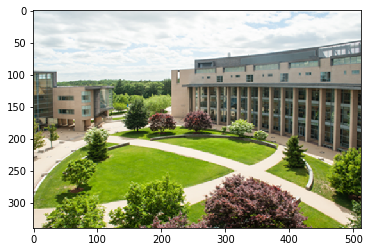

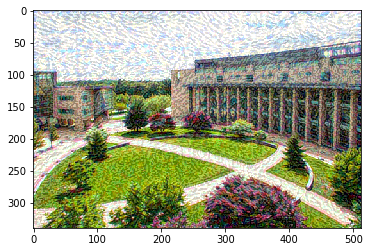

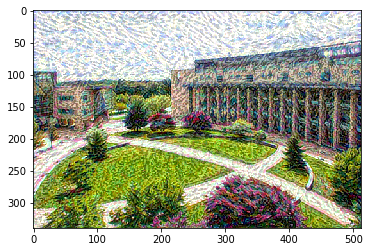

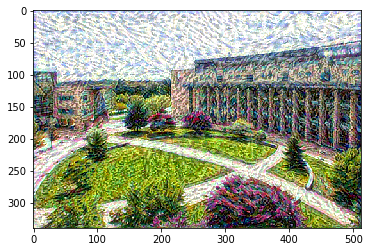

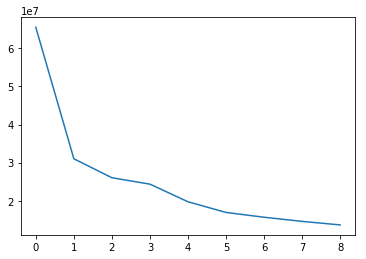

In [32]:
run(3,3)
plt.figure()
plt.plot(losses)
plt.show()

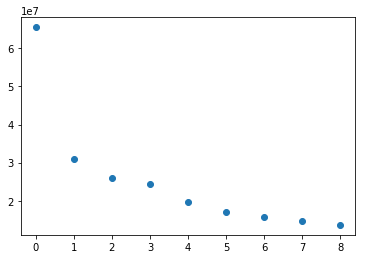

In [33]:
plt.figure()
plt.plot(losses, 'o')
plt.show()